Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/loan_prediction.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df = df.drop('Loan_ID',axis = 1)

In [5]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Now let’s fill in the missing values. In categorical columns, we can fill in missing values with the mode of each column. The mode represents the value that appears most often in the column and is an appropriate choice when dealing with categorical data.

In [7]:
# Fill missing values in categorical columns with mode
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)

To fill in the missing values of numerical columns, we have to choose appropriate measures:

1. We can fill in the missing values of the loan amount column with the median value. The median is an appropriate measure to fill in missing values when dealing with skewed distributions or when outliers are present in the data.
2. We can fill in the missing values of the loan amount term column with the mode value of the column. Since the term of the loan amount is a discrete value, the mode is an appropriate metric to use.
3. We can fill in the missing values of the credit history column with the mode value. Since credit history is a binary variable (0 or 1), the mode represents the most common value and is an appropriate choice for filling in missing values.

In [8]:
# Fill missing values in loan amount with median
df['LoanAmount'].fillna(df['LoanAmount'].median(),inplace=True)

# Fill missing values in loan amount term with mode
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace=True)

# Fill missing values in credit history with mode
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)

### EDA

Now let’s have a look at the distribution of the loan status column

In [9]:
loan_status_count = df['Loan_Status'].value_counts()
fig_loan_status = px.pie(loan_status_count,
                         names = loan_status_count.index,
                         title = 'Loan Approval Status')
fig_loan_status.show()

Now let's have look at the distribution of gender column

In [10]:
gender_count = df['Gender'].value_counts()
fig = px.bar(gender_count,
             x = gender_count.index,
             y = gender_count.values,
             title = 'Gender Distribution')
fig.show()

Now let's have look at distribution of martial status column

In [11]:
married_count = df['Married'].value_counts()
fig = px.bar(married_count,
             x = married_count.index,
             y = married_count.values,
             title = 'Martial Status Distribution')

fig.show()

Now let's have look at distribution of edducation column

In [12]:
edu_count = df['Education'].value_counts()
fig = px.bar(edu_count,
             x = edu_count.index,
             y = edu_count.values,
             title = 'Education Distribution')

fig.show()

Now let's have look at distribution of self-employement column

In [13]:
self_emp_count = df['Self_Employed'].value_counts()
fig = px.bar(self_emp_count,
             x = self_emp_count.index,
             y = self_emp_count.values,
             title = 'Self Employment Distribution')

fig.show()

Now let’s have a look at the distribution of the Applicant Income column

In [14]:
fig_applicant_income = px.histogram(df, x='ApplicantIncome',
                                    title='Applicant Income Distribution')
fig_applicant_income.show()

Now let’s have a look at the relationship between the income of the loan applicant and the loan status.

In [15]:
fig_income = px.box(df, x = 'Loan_Status',
                    y = 'ApplicantIncome',
                    color = 'Loan_Status',
                    title = 'LoanStatus vs ApplicantIncome')
fig_income.show()

Now let’s have a look at the relationship between the income of the loan applicant and the loan status.

In [16]:
# Calculate the IQR
Q1 = df['ApplicantIncome'].quantile(0.25)
Q3 = df['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove Outliers
df = df[(df['ApplicantIncome'] >= lower_bound) & (df['ApplicantIncome'] <= upper_bound)]

Now let’s have a look at the relationship between the income of the loan co-applicant and the loan status.

In [17]:
fig_coapplicant_income = px.box(df,
                                x='Loan_Status',
                                y='CoapplicantIncome',
                                color="Loan_Status",
                                title='Loan_Status vs CoapplicantIncome')
fig_coapplicant_income.show()

The income of the loan co-applicant also contains outliers. Let’s remove the outliers from this column as well....

In [18]:
# Calculate the IQR
Q1 = df['CoapplicantIncome'].quantile(0.25)
Q3 = df['CoapplicantIncome'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove Outliers
df = df[(df['CoapplicantIncome'] >= lower_bound) & (df['CoapplicantIncome'] <= upper_bound)]

Now let’s have a look at the relationship between the loan amount and the loan status.

In [19]:
fig_loan_amount = px.box(df, x='Loan_Status',
                         y='LoanAmount',
                         color="Loan_Status",
                         title='Loan_Status vs LoanAmount')
fig_loan_amount.show()

Now let’s have a look at the relationship between credit history and loan status.

In [20]:
fig_credit_history = px.histogram(df, x='Credit_History', color='Loan_Status',
                                  barmode='group',
                                  title='Loan_Status vs Credit_His')
fig_credit_history.show()

Now let’s have a look at the relationship between the property area and the loan status.

In [21]:
fig_property_area = px.histogram(df, x='Property_Area', color='Loan_Status',
                                 barmode='group',
                                title='Loan_Status vs Property_Area')
fig_property_area.show()

## Data Preparation and Training Loan Approval Prediction Model

In this step, we will:

1. convert categorical columns into numerical ones;
2. split the data into training and test sets;
3. scale the numerical features;
4. train the loan approval prediction model.

In [22]:
# Convert categorical columns to numerical using one-hot encoding
categorical = ['Gender','Married','Dependents','Self_Employed','Education','Property_Area']
df = pd.get_dummies(df,columns=categorical)

Remove Outliers & Infinite values

In [23]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

<ipython-input-23-638683b93e01>:1: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-23-638683b93e01>:2: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-23-638683b93e01>:5: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



Skewed Distribution Treatment


In [24]:
# Square Root Transformation

df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

In [25]:
# Split the dataset into features (x) and target (y)
x = df.drop('Loan_Status',axis=1)
y = df['Loan_Status']

# Split the train test data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state = 42)

# Scale the numerical columns using StandardScaler
scaler = MinMaxScaler()
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
x_train[numerical] = scaler.fit_transform(x_train[numerical])
x_test[numerical] = scaler.transform(x_test[numerical])

1. Random Forest

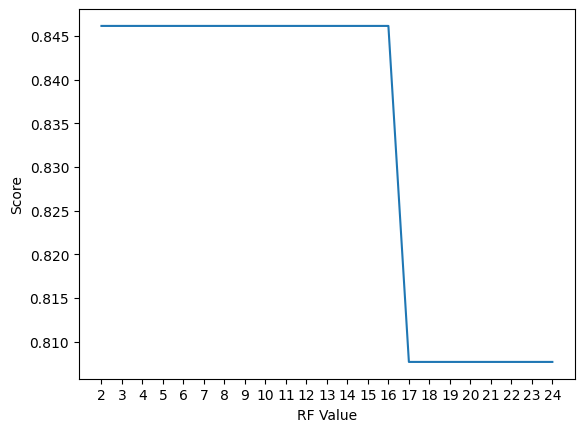

Random Forest Accuracy:  84.62%


In [26]:
scoreListRF = []
for i in range(2,25):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    RFclassifier.fit(x_train, y_train)
    scoreListRF.append(RFclassifier.score(x_test, y_test))

plt.plot(range(2,25), scoreListRF)
plt.xticks(np.arange(2,25,1))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RFAcc = max(scoreListRF)
print("Random Forest Accuracy:  {:.2f}%".format(RFAcc*100))

2. Gradient Boosting

In [27]:
paramsGB={'n_estimators':[100,200,300,400,500],
      'max_depth':[1,2,3,4,5],
      'subsample':[0.5,1],
      'max_leaf_nodes':[2,5,10,20,30,40,50]}

GB = RandomizedSearchCV(GradientBoostingClassifier(), paramsGB, cv=17)
GB.fit(x_train, y_train)

print(GB.best_estimator_)
print(GB.best_score_)
print(GB.best_params_)
print(GB.best_index_)

GradientBoostingClassifier(max_leaf_nodes=10, n_estimators=500, subsample=1)
0.8333333333333334
{'subsample': 1, 'n_estimators': 500, 'max_leaf_nodes': 10, 'max_depth': 3}
5


In [28]:
GBclassifier = GradientBoostingClassifier(subsample=0.5, n_estimators=400, max_depth=4, max_leaf_nodes=10)
GBclassifier.fit(x_train, y_train)

y_pred = GBclassifier.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

GBAcc = accuracy_score(y_pred,y_test)
print('Gradient Boosting accuracy: {:.2f}%'.format(GBAcc*100))

              precision    recall  f1-score   support

           N       0.00      0.00      0.00         4
           Y       0.84      0.95      0.89        22

    accuracy                           0.81        26
   macro avg       0.42      0.48      0.45        26
weighted avg       0.71      0.81      0.76        26

[[ 0  4]
 [ 1 21]]
Gradient Boosting accuracy: 80.77%


### Model Comparison

In [29]:
compare = pd.DataFrame({'Model': ['Random Forest', 'Gradient Boost'],
                        'Accuracy': [RFAcc*100, GBAcc*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Random Forest,84.615385
1,Gradient Boost,80.769231


## Summary

#### Loan approval prediction involves the analysis of various factors, such as the applicant’s financial history, income, credit rating, employment status, and other relevant attributes. By leveraging historical loan data and applying machine learning algorithms, businesses can build models to determine loan approvals for new applicants. I hope you liked this project on Loan Approval Prediction with Machine Learning using Python.